In [47]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
import string
import matplotlib.pyplot as plt
import random
%matplotlib inline

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#from nltk.corpus import stopwords
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix

import joblib


### Part 1  prepare for training data 

In [48]:
# set aside 2000 charts from wellcare for later unbiased testing

#ibc_df2 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_Data_180219.csv')  # check the 2019 data
#ibc_df2.head() #139891
#list2=ibc_df2['chart_id'].unique()
#len(list2)  # 12104
#len(set(list2)) #12104
#import random
#save4testwellcarelist = random.sample(set(list2), 2000)  # set aside for testing
#len(save4testwellcarelist)  #2000
#ibc_df2_saved = ibc_df2[ibc_df2['chart_id'].isin(save4testwellcarelist)]
#len(ibc_df2_saved)   #23983
#ibc_df2_used = ibc_df2[ibc_df2['chart_id'].isin(save4testwellcarelist)== False]
#len(ibc_df2_used) # 115908
#ibc_df2_saved.to_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_180219_4testing.csv')
#ibc_df2_used.to_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_180219_4training.csv')
#list2019train=ibc_df2_used['chart_id'].unique()
#list2019test=ibc_df2_saved['chart_id'].unique()

In [49]:
#ibc_df3 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_041018_4training.csv')
#len(ibc_df3)  #453332
#ibc_df3.head()
#list3=ibc_df3['chart_id'].unique()
#len(list3)  # 8926
#ibc_df3a = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_041018_4testing.csv')
#print(len(ibc_df3a))  #102325
#list3a=ibc_df3a['chart_id'].unique()
#print(len(list3a))  # 2000


In [50]:
# load wellcare training and testin data
well_df1 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_041018_4training.csv')
#well_df2 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_180219_4training.csv')
#well_df_t1 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_041018_4testing.csv')
#well_df_t2 = pd.read_csv('/home/jovyan/work/Model_Training_Data/Wellcare_data_180219_4testing.csv')
#well_data=pd.concat([well_df1,well_df2])
well_data=well_df1
#well_data_t=pd.concat([well_df_t1,well_df_t2])
print(len(well_data))
#print(len(well_data_t))

453332


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# load in IBC data
ibc_df1 = pd.read_csv('/home/jovyan/work/Model_Training_Data/IBC_181218.csv')
#ibc_df1.head()
#list1=ibc_df1['chart_id'].unique()
#len(list1)  #32571
print(len(ibc_df1)) #332158

332158


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [52]:
# combine these IBC and wellcare data 
#print(len(ibc_df3))
all_data=pd.concat([ibc_df1,well_data])  # model 1 use ibc, two wellcare data
#all_data=well_data  # model 2, use two wellcare data
#all_data=ibc_df1   # just use ibc data to compare
print(len(all_data))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


785490


In [53]:
all_data.isnull().sum()

15char              8943
25char              8951
50char              8968
75char              8987
Unnamed: 0             0
Unnamed: 0.1      332158
chart_id               0
code_id                0
deleted           203549
deleted_reason    385655
end_offset             0
flag                   0
label                  0
start_offset           0
text                6194
dtype: int64

In [54]:
all_data.head()

,15char,25char,50char,75char,Unnamed: 0,Unnamed: 0.1,chart_id,code_id,deleted,deleted_reason,end_offset,flag,label,start_offset,text
0,cess calories (E66.01).,due to excess calories (E66.01). ...,sessment Morbid obesity due to excess calori...,.7). Assessment Morbid obe...,0,NaN,002803945_161667176A_2016_001,E6601,NaN,NaN,14257,0,agreed,14251,e66.01
1,cess calories (E66.01). Impre,due to excess calories (E66.01). Impre...,sessment Morbid obesity due to excess calori...,ise. Assessment Morbid obe...,1,NaN,002803945_161667176A_2016_001,E6601,NaN,NaN,22451,0,agreed,22445,e66.01
2,m cholesterol (E78.9).,vated serum cholesterol (E78.9). ...,Assessment Elevated serum cholester...,izures (F44.5). Assessment ...,2,NaN,002803945_161667176A_2016_001,E789,NaN,NaN,14506,0,agreed,14501,e78.9
3,"sion, chronic (F32.9). Impression","jor depression, chronic (F32.9). Impressions...","ad injury. AssessmentMajor depression, chron...","etter w meds, flared w head injury. Assessme...",3,NaN,002803945_161667176A_2016_001,F329,NaN,NaN,21562,0,agreed,21557,f32.9
4,"pap finding Major depression,08/10/2016 ch","abnormal pap finding Major depression,08/1...",:00 PM 3/36 unspecified abnormal pap findin...,07/28/1977 09/19/2016 06:00 PM 3/36 unspeci...,4,NaN,002803945_161667176A_2016_001,F329,NaN,NaN,17590,0,agreed,17574,Major depression


In [55]:
all_data= all_data.replace(np.nan,'',regex = True)
print(len(all_data))

785490


In [56]:
print(len(all_data.loc[all_data['label']== 'deleted']))
print(len(all_data.loc[all_data['label']== 'agreed']))
print(len(all_data.loc[all_data['label']== 'added']))

406382
235252
143856


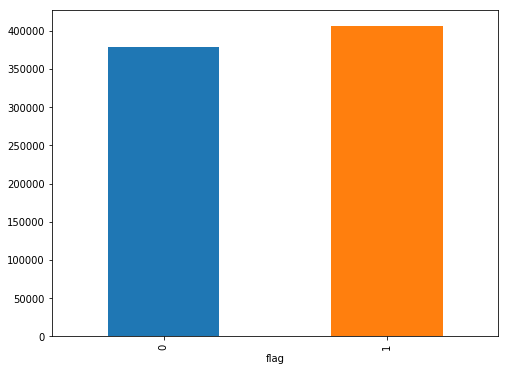

In [57]:
#import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
all_data.groupby('flag').code_id.count().plot.bar(ylim=0)
plt.show()

In [58]:
all_data.groupby(['flag']).size()  # 0 is agreed and added   1 is  deleted

flag
0    379108
1    406382
dtype: int64

#### select data, and create multilabel for building deletion model

In [59]:
# selecting data based on deletion reason
all_data['deleted_reason'].unique()

array(['', 'not_doctors_note', 'phoneORaddressORother_number',
       'not_relevant', 'preventative_screening', 'negation', 'other',
       'family_history', 'incorrect_year_of_service',
       'Incorrect Specification - Non-Risk Adjusted', 'incorrect_acronym',
       'repeated_instance', 'medical_history', 'incorrect_spec',
       'incorrect_version'], dtype=object)

In [60]:
all_data=all_data.reset_index(drop=True) 

In [61]:
#all_data = all_data.replace(np.nan,'',regex = True)  # cannot use it, it make all 
#len(all_data[all_data['deleted_reason'].isnull()])  # 470089 out of 901398  have  null deletion reason  # 
#len(all_data[all_data['deleted'].isnull()])    # 217985 out of 901398 have null deleted, those are agreed +addition
#print(253610 + 209932)    #463542 are agreed + addition    437856 deleted
# so there are some deleted reasons 470089-463542 have null deletion reasons
# select non-deleted label data
all_false = all_data.loc[all_data['label']=='agreed']
#all_false = all_data.loc[all_data['deleted_reason']!= 'not_relevant']
#all_false['flag']= 1    # reverse the flag here
all_falsea = all_data.loc[all_data['label']=='added']
#all_falsea['flag']= 1 
trainDF2 = pd.concat([all_false,all_falsea])
len(trainDF2)

379108

In [62]:
deletion_df= all_data[~all_data.index.isin(trainDF2.index)]
len(deletion_df)  # correct number 

406382

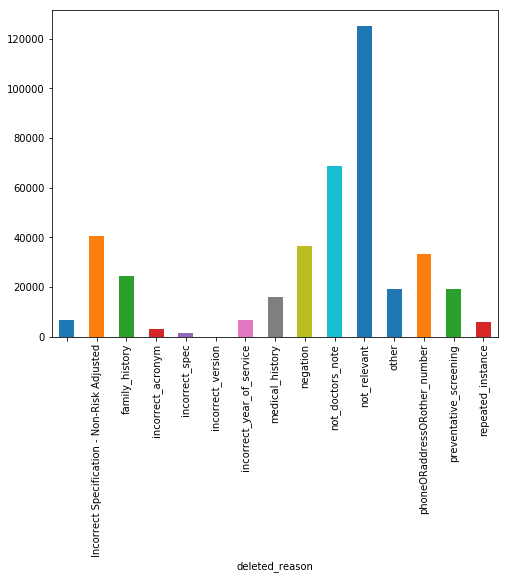

In [63]:
fig = plt.figure(figsize=(8,6))
deletion_df.groupby('deleted_reason').code_id.count().plot.bar(ylim=0)
plt.show()

In [64]:
deletelist=['not_doctors_note','phoneORaddressORother_number','not_relevant','preventative_screening', 'negation','family_history','incorrect_acronym','medical_history']
len(deletelist)
deletion_sel=deletion_df[deletion_df['deleted_reason'].isin(deletelist)]
print(len(deletion_sel))

326067


In [65]:
##test=deletion_sel['deleted_reason'].replace(np.nan,'',regex = True)
##deletion_sel['deleted_reason']=deletion_sel['deleted_reason'].replace(r'\s+', np.nan, regex=True)
#len(deletion_df[deletion_df['deleted_reason'].isnull()])   
# 6547 rows  have nan deletion-reasons, can remove them, or keep them if needed later
#deletion_sel=deletion_df[~deletion_df['deleted_reason'].isnull()]
#len(deletion_sel)

In [66]:
deletion_sel['deleted_reason'].unique()

array(['not_doctors_note', 'phoneORaddressORother_number', 'not_relevant',
       'preventative_screening', 'negation', 'family_history',
       'incorrect_acronym', 'medical_history'], dtype=object)

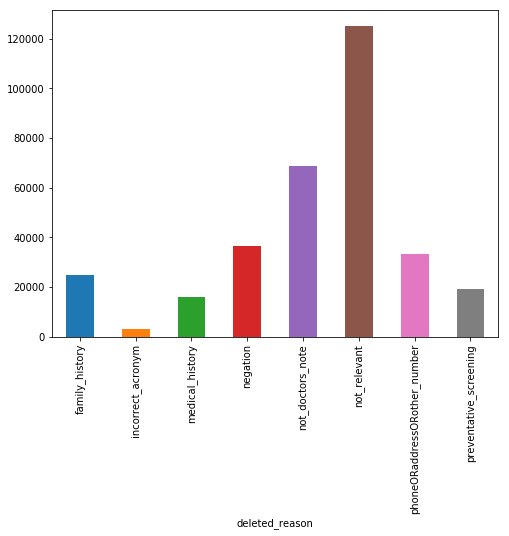

In [67]:
fig = plt.figure(figsize=(8,6))
deletion_sel.groupby('deleted_reason').code_id.count().plot.bar(ylim=0)
plt.show()

# after selection, there are only 8 classes of deleted data

In [68]:
print(len(deletion_sel))
deletion_sel1= deletion_sel.replace(np.nan,'',regex = True)
print(len(deletion_sel1))

326067
326067


In [69]:
# Assigning multi_class labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(deletion_sel['deleted_reason'])
le.classes_
deletion_sel['multiclass_label']=le.transform(deletion_sel['deleted_reason'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
deletion_sel['multiclass_label'].unique()

array([4, 6, 5, 7, 3, 0, 1, 2])

In [71]:
le.inverse_transform([ 0,1,2,3,4,5,6,7])   # 8 different labels, and now match with the deletion reasons

array(['family_history', 'incorrect_acronym', 'medical_history',
       'negation', 'not_doctors_note', 'not_relevant',
       'phoneORaddressORother_number', 'preventative_screening'], dtype=object)

In [72]:
#all_true = all_data.loc[all_data['deleted_reason']== 'not_relevant']
# 
#all_true['flag']= 0
trainDF2['multiclass_label']= 8    # will assign one different label here
trainDF = pd.concat([deletion_sel,trainDF2])
trainDF['flag']= trainDF['multiclass_label']
print(len(trainDF))

705175


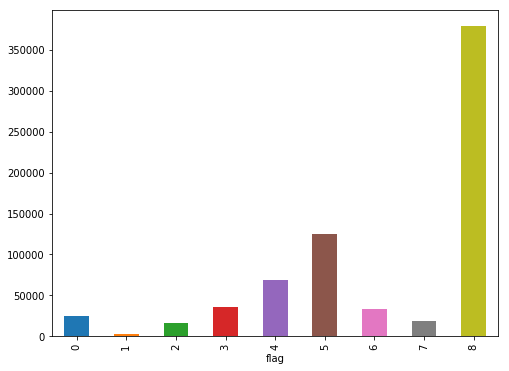

In [73]:
fig = plt.figure(figsize=(8,6))
trainDF.groupby('flag').code_id.count().plot.bar(ylim=0)
plt.show()       # 0-7 are different deletion classes  8 is agreed+added

### Part 2. Data  processing

In [74]:
#import re
#code_id = ['Z794','E119']
trainDF['text75'] = trainDF['75char']
trainDF = trainDF[pd.notnull(trainDF['text75'])]
print(len(trainDF))
#trainDF = trainDF[pd.notnull(trainDF['text'])]
#print(len(trainDF))
#trainDF = trainDF[trainDF['code_id'].isin(code_id)]
#trainDF = trainDF[trainDF['text75'].str.contains('cholesterol',flags=re.IGNORECASE)]
#trainDF = trainDF[trainDF['text'].str.contains(phrase,flags=re.IGNORECASE)]  # here use phrase variable to select data
#trainDF = trainDF[trainDF['text75'].str.contains(r'^[0-9]')]
#print(len(trainDF))
trainDF.head()

705175


,15char,25char,50char,75char,Unnamed: 0,Unnamed: 0.1,chart_id,code_id,deleted,deleted_reason,end_offset,flag,label,start_offset,text,multiclass_label,text75
128910,eneral Mental: anxious General Hydr,normal General Mental: anxious General Hyd...,", dry General Habitus: normal General Ment...","age General Skin: warm, dry General Habit...",128910,,002803945_161667176A_2016_001,F411,1,not_doctors_note,53146,4,deleted,53139,anxious,4,"age General Skin: warm, dry General Habit..."
128911,L{AB} 110[98-110]MEQ/L{AB} *,5-5.1]MEQ/L{AB} 110[98-110]MEQ/L{AB} * 19[...,5-145] MEQ/L{AB} 3.9[3.5-5.1]MEQ/L{AB} 110...,-1.11] MG/DL{AB} 137[135-145] MEQ/L{AB} 3....,128911,,002803945_161667176A_2016_001,I10,1,phoneORaddressORother_number,603,6,deleted,600,110,6,-1.11] MG/DL{AB} 137[135-145] MEQ/L{AB} 3....
128912,Time: 02/04/16 1609 Transcribed,tion Date/Time: 02/04/16 1609 Transcribed By...,ure on File>> Transcription Date/Time: 02/04...,: 02/04/16 2316 <<Signature on File>> Trans...,128912,,002803945_161667176A_2016_001,I609,1,phoneORaddressORother_number,50507,6,deleted,50503,1609,6,: 02/04/16 2316 <<Signature on File>> Trans...
128913,p ight ownerof ffis page) - Your,** (see tap ight ownerof ffis page) - Your e...,ssword. - Your User 11-.)** (see tap ight owne...,Wail with your secure password. - Your User 1...,128913,,002804844_199286931A_2016_001,A8183,1,not_relevant,37766,5,deleted,37762,ffis,5,Wail with your secure password. - Your User 1...
128914,1/11242C15 12=WD AM B,31101 1/11242C15 12=WD AM BLACK...,W13h937 12169017131101 1/11242C15...,171 BADMAN DOROTIV1 W13h937 12169...,128914,,002804844_199286931A_2016_001,E8301,1,not_relevant,65825,5,deleted,65823,WD,5,171 BADMAN DOROTIV1 W13h937 12169...


In [75]:
import string
trainDF['cleaned_data'] = trainDF['text75'].apply(lambda x: x.lower())
trainDF['cleaned_data'] = trainDF['cleaned_data'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
#trainDF['cleaned_data']= trainDF['cleaned_data'].apply(lambda x: x.translate(str.maketrans('','','1234567890')))

In [76]:

nltk.download('stopwords')
stop = stopwords.words('english')

trainDF['cleaned_data']= trainDF['cleaned_data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
trainDF['cleaned_data']=trainDF['cleaned_data'].str.findall('\w{2,}').str.join(' ')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


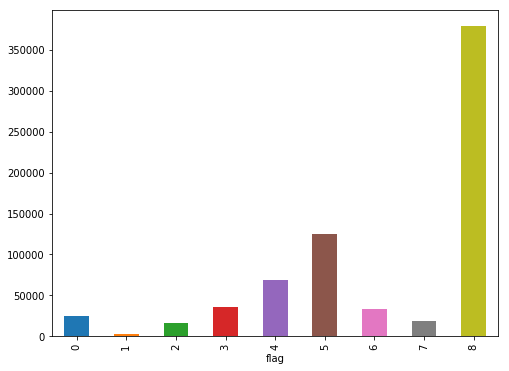

flag
0     24609
1      2907
2     15943
3     36487
4     68557
5    125119
6     33146
7     19299
8    379108
dtype: int64

In [77]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
trainDF.groupby('flag').chart_id.count().plot.bar(ylim=0)
plt.show()
trainDF.groupby(['flag']).size()                 # 0 is agreed, 1 is deleted 

In [78]:
#trainDF_copy=trainDF  # now save a copy of trainDF, in case the other columns are needed
col = ['cleaned_data','flag']
trainDF = trainDF[col]
trainDF = trainDF[pd.notnull(trainDF['cleaned_data'])]
trainDF.columns = ['text75','flag']
trainDF.head()

,text75,flag
128910,age general skin warm dry general habitus norm...,4
128911,111 mgdlab 137135145 meqlab 393551meqlab 11098...,6
128912,020416 2316 signature file transcription datet...,6
128913,wail secure password user 11 see tap ight owne...,5
128914,171 badman dorotiv1 w13h937 12169017131101 111...,5


In [79]:
trainDF1=trainDF.reset_index(drop=True)
trainDF1.head()

,text75,flag
0,age general skin warm dry general habitus norm...,4
1,111 mgdlab 137135145 meqlab 393551meqlab 11098...,6
2,020416 2316 signature file transcription datet...,6
3,wail secure password user 11 see tap ight owne...,5
4,171 badman dorotiv1 w13h937 12169017131101 111...,5


### Part 3. Model Building

####  Try different deep learning methods

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [43]:
trainDF.flag.value_counts()

8    379108
5    125119
4     68557
3     36487
6     33146
0     24609
7     19299
2     15943
1      2907
Name: flag, dtype: int64

In [115]:
# to make it more balanced
num_of_categories = 45000    # to make a balanced class
shuffled = trainDF1.reindex(np.random.permutation(trainDF1.index))
a = shuffled[shuffled['flag'] == 0][:num_of_categories]
b = shuffled[shuffled['flag'] == 1][:num_of_categories]
c = shuffled[shuffled['flag'] == 2][:num_of_categories]
d = shuffled[shuffled['flag'] == 3][:num_of_categories]
e = shuffled[shuffled['flag'] == 4][:num_of_categories]
f = shuffled[shuffled['flag'] == 5][:num_of_categories]
g = shuffled[shuffled['flag'] == 6][:num_of_categories]
h = shuffled[shuffled['flag'] == 7][:num_of_categories]
i = shuffled[shuffled['flag'] == 8][:num_of_categories]
concated = pd.concat([a,b,c,d,e,f,g,h,i], ignore_index=True)

#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [116]:
concated.head()

,text75,flag,LABEL
142607,7ownerdonerivan document typeestablished site ...,5,0
51064,carotid bruit jugular venous distention lympha...,3,0
188510,ysician surgery yali tu md 753 kg 166 lbs 190c...,6,0
31843,01132016 followup examination z09 v6759 since ...,2,0
57825,llitus type cancer coronary artery disease cad...,3,0


In [182]:
#One-hot encode the lab
concated.loc[concated['flag'] == 0, 'LABEL'] = 0
concated.loc[concated['flag'] == 1, 'LABEL'] = 1
concated.loc[concated['flag'] == 2, 'LABEL'] = 2
concated.loc[concated['flag'] == 3, 'LABEL'] = 3
concated.loc[concated['flag'] == 4, 'LABEL'] = 4
concated.loc[concated['flag'] == 5, 'LABEL'] = 5
concated.loc[concated['flag'] == 6, 'LABEL'] = 6
concated.loc[concated['flag'] == 7, 'LABEL'] = 7
concated.loc[concated['flag'] == 8, 'LABEL'] = 8
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=9)
print(labels[:10])

142607    5
51064     3
188510    6
31843     2
57825     3
130927    5
147093    5
9721      0
176397    6
225340    8
Name: LABEL, dtype: int64
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [183]:
if 'flag' in concated.keys():
    concated.drop(['flag'], axis=1)

In [198]:
concated.head()

,text75,flag,LABEL
142607,7ownerdonerivan document typeestablished site ...,5,5
51064,carotid bruit jugular venous distention lympha...,3,3
188510,ysician surgery yali tu md 753 kg 166 lbs 190c...,6,6
31843,01132016 followup examination z09 v6759 since ...,2,2
57825,llitus type cancer coronary artery disease cad...,3,3


In [225]:
n_most_common_words = 100000
max_len =32
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['text75'].values)
#tokenizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

#tokenizer.fit_on_texts(concated['text75'].values)

sequences = tokenizer.texts_to_sequences(concated['text75'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 311433 unique tokens.


In [220]:
X[1604]

array([32232,  1404,   832,  2853,  1404,  1407, 41786,  1404,   182,
        1443,  1404, 32232,  1404,   832,   437,  1404,  1407, 41787,
        1404,   182,  1412,  1404,   110,  1434,  1404,   832,  1309,
        1404,  1407, 66718], dtype=int32)

In [226]:
#(X!=0).argmax(axis=0) # find the first non zero row for each column
np.count_nonzero(X, axis=0)   # count how many non zero values in each column

array([    73,    140,    222,    361,    568,    994,   1556,   2623,
         4253,   7284,  12733,  22117,  37830,  61461,  93488, 130634,
       166902, 198456, 221815, 238127, 247801, 253735, 257788, 260305,
       261989, 263168, 264088, 264745, 265237, 265631, 265943, 266276])

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [228]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [240]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

((200543, 32), (200543, 9), (66848, 32), (66848, 9))


#### B. Using CNN+LSTM

In [235]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [255]:
epochs=3
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=5,activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 32, 128)           12800000  
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 28, 64)            41024     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 7, 64)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_19 (Dense)             (None, 9)                 585       
Total params: 12,874,633
Trainable params: 12,874,633
Non-trainable params: 0
________________________________________________________________

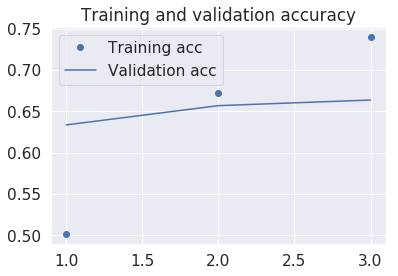

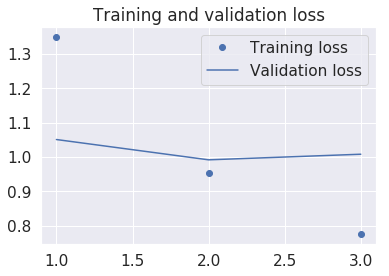

In [256]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
## Get weights
'''
conv_embds = model.layers[0].get_weights()[0]
## Plotting function
def plot_words(data, start, stop, step):
    trace = go.Scatter(
        x = data[start:stop:step,0], 
        y = data[start:stop:step, 1],
        mode = 'markers',
        text= word_list[start:stop:step]
    )
    layout = dict(title= 't-SNE 1 vs t-SNE 2',
                  yaxis = dict(title='t-SNE 2'),
                  xaxis = dict(title='t-SNE 1'),
                  hovermode= 'closest')
    fig = dict(data = [trace], layout= layout)
    py.iplot(fig)
## Visualize words in two dimensions 
conv_tsne_embds = TSNE(n_components=2).fit_transform(conv_embds)
plot_words(conv_tsne_embds, 0, 2000, 1)
'''

#### A. Using LSTM only

In [230]:
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 128)           12800000  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 32, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 585       
Total params: 12,849,993
Trainable params: 12,849,993
Non-trainable params: 0
_________________________________________________________________
None
Train on 160434 samples, validate on 40109 samples
Epoch 1/10
160434/160434 [==============================] - 102s 635us/step - loss: 1.6296 - acc: 0.3830 - val_loss: 1.2195 - val_acc: 0.5582
Epoch 2/10
160434/160434 [==============================] - 99s 

In [206]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

66848/66848 [==============================] - 14s 205us/step
Test set
  Loss: 1.005
  Accuracy: 0.679


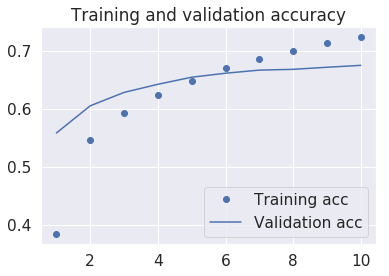

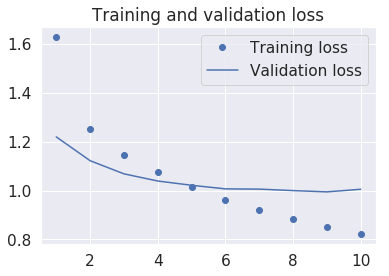

In [231]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [232]:
# one example of prediction
txt = ['gkins diagnosed cancer brother alive stroke diagnosed stroke sister alive breast cancer diagnosed cancer sister aliv']
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
classlabels = ['Class 0:family_history', 'Class 1:incorrect_acronym', 'Class 2:medical_history',
       'Class 3:negation', 'Class 4:not_doctors_note', 'Class 5:not_relevant',
       'Class 6:phoneORaddressORother_number', 'Class 7:preventative_screening', 'Class 8:agreedandadded']
print(pred, classlabels[np.argmax(pred)])

labelsnum = [0,1,2,3,4,5,6,7,8]
print(pred, labelsnum[np.argmax(pred)])

[[  9.93523479e-01   1.02251433e-05   1.74961286e-03   2.62479484e-03
    7.95224332e-04   5.24100789e-04   6.31219009e-05   1.52038134e-04
    5.57457271e-04]] Class 0:family_history
[[  9.93523479e-01   1.02251433e-05   1.74961286e-03   2.62479484e-03
    7.95224332e-04   5.24100789e-04   6.31219009e-05   1.52038134e-04
    5.57457271e-04]] 0


Test accuracy is 0.6790928674006702
[[5570    0   93  129   57   44    6   21   99]
 [   4  113    4   35   53  351   96   21   48]
 [  86    0 2820  161  170   85   13   17  737]
 [ 290   11  167 6392  742  705   46  196  608]
 [  90   10  235  715 6554 1511  362  247 1489]
 [ 131   94  243 1108 2133 4592  979  291 1645]
 [  14    8   20   30  234  442 7267   19  162]
 [  24    7   12  189  321  374   48 3755  111]
 [  99    3  436  459 1098  721  108  135 8333]]


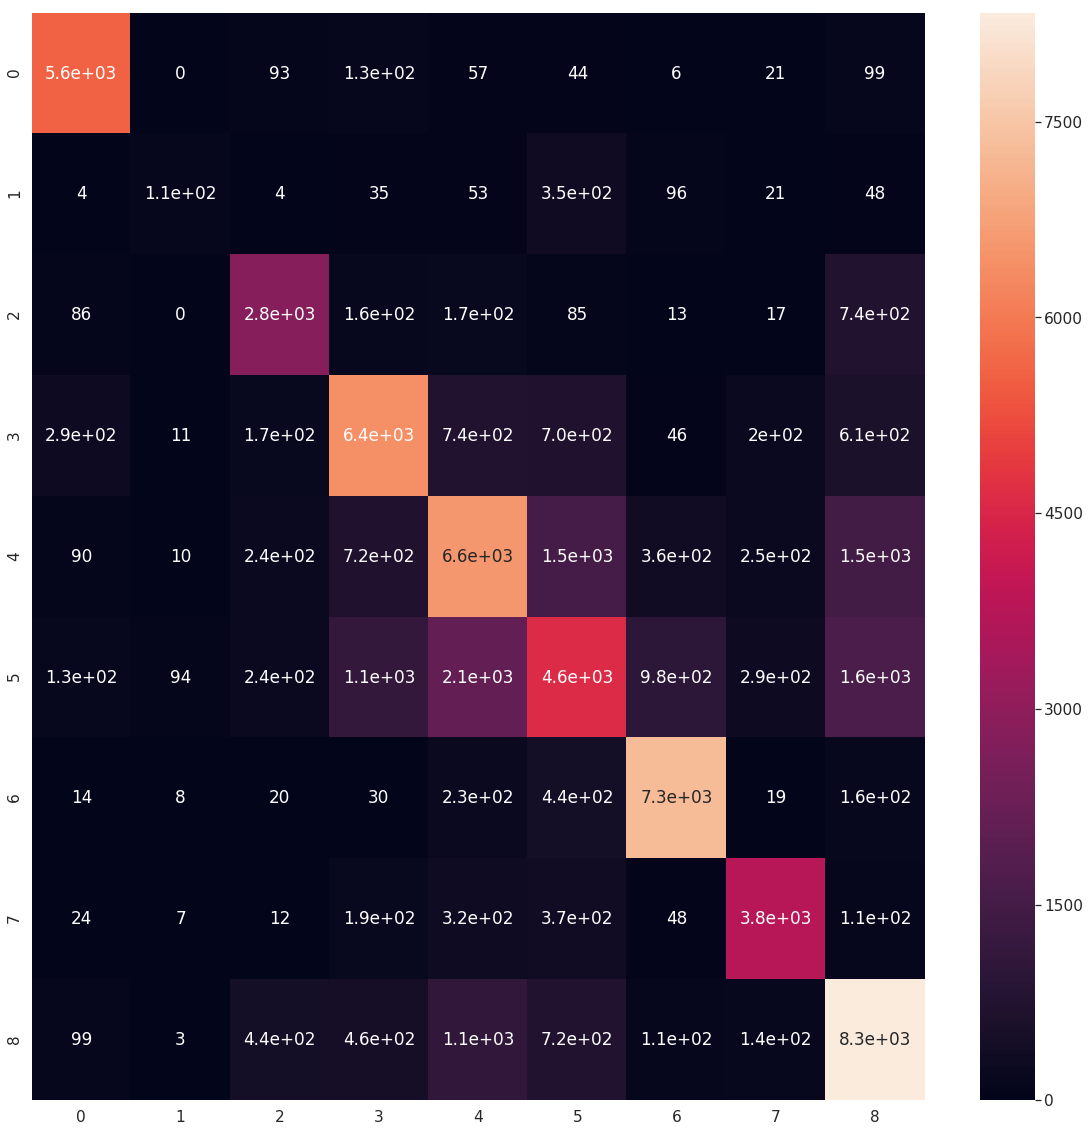

In [209]:
# now use other metrics to evaluate the prediction
# for direct multiclass
prediction = model.predict(X_test)
finallabel=[labelsnum[np.argmax(prediction[i,:])] for i in range(len(prediction))]
y_testori=np.argmax(y_test, axis=1, out=None)

print('Test accuracy is {}'.format(accuracy_score(y_testori, finallabel)))

conf_mat = confusion_matrix(y_testori, finallabel)
print(conf_mat)
#plt.matshow(conf_mat)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (20,20))
sns.heatmap(conf_mat, annot=True)

In [233]:
print('Test accuracy is {}'.format(accuracy_score(y_testori, finallabel)))
target_names = ['Class 0:family_history', 'Class 1:incorrect_acronym', 'Class 2:medical_history',
       'Class 3:negation', 'Class 4:not_doctors_note', 'Class 5:not_relevant',
       'Class 6:phoneORaddressORother_number', 'Class 7:preventative_screening', 'Class 8:agreedandadded']
print(classification_report(y_testori, finallabel, target_names=target_names))

Test accuracy is 0.6790928674006702
                                      precision    recall  f1-score   support

              Class 0:family_history       0.88      0.93      0.90      6019
           Class 1:incorrect_acronym       0.46      0.16      0.23       725
             Class 2:medical_history       0.70      0.69      0.69      4089
                    Class 3:negation       0.69      0.70      0.70      9157
            Class 4:not_doctors_note       0.58      0.58      0.58     11213
                Class 5:not_relevant       0.52      0.41      0.46     11216
Class 6:phoneORaddressORother_number       0.81      0.89      0.85      8196
      Class 7:preventative_screening       0.80      0.78      0.79      4841
              Class 8:agreedandadded       0.63      0.73      0.68     11392

                           micro avg       0.68      0.68      0.68     66848
                           macro avg       0.68      0.65      0.65     66848
                        we

after converting to binary class:
Test accuracy is 0.8809538056486357
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     55456
           1       0.63      0.73      0.68     11392

   micro avg       0.88      0.88      0.88     66848
   macro avg       0.79      0.82      0.80     66848
weighted avg       0.89      0.88      0.88     66848



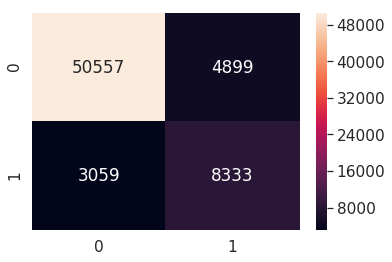

In [234]:
# now divide the deletion vs agreed+added 
print('after converting to binary class:')
valid_y_2b = (y_testori > 7).astype(np.int)
#prediction_2b= (finallabel > 7).astype(np.int)
prediction_2b= (np.array(finallabel) > 7).astype(np.int)  

print('Test accuracy is {}'.format(accuracy_score(valid_y_2b, prediction_2b)))
conf_mat = confusion_matrix(valid_y_2b, prediction_2b)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(valid_y_2b,prediction_2b))

####  Previous Machine learning Classifier methods, put here for comparison and reference

In [ ]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text75'], trainDF['flag'],random_state=42, test_size=0.25)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [ ]:
import joblib
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

... Processing


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

Test accuracy is 0.8067027039447607
[[ 5518     0    14    74    51   134     6    18   402]
 [    1   174     1    18    25   362    40     8   101]
 [   39     0  2794    26    40   139     2     9   968]
 [  148     9    22  5859   382  1226    17   118  1302]
 [   91    12    29   287  9402  3446   336   173  3384]
 [  139    78   111   819  2132 19620  1362   395  6442]
 [    2     6    11     9   137  1051  6577    16   450]
 [   10     4     3    79   234   675    30  3344   391]
 [  305    10   160   336   960  3352   319   161 87142]]


['../picklefolder_ngrams/DeleteReason_multiclass_Feb2619_LRmodelV3.pickle']

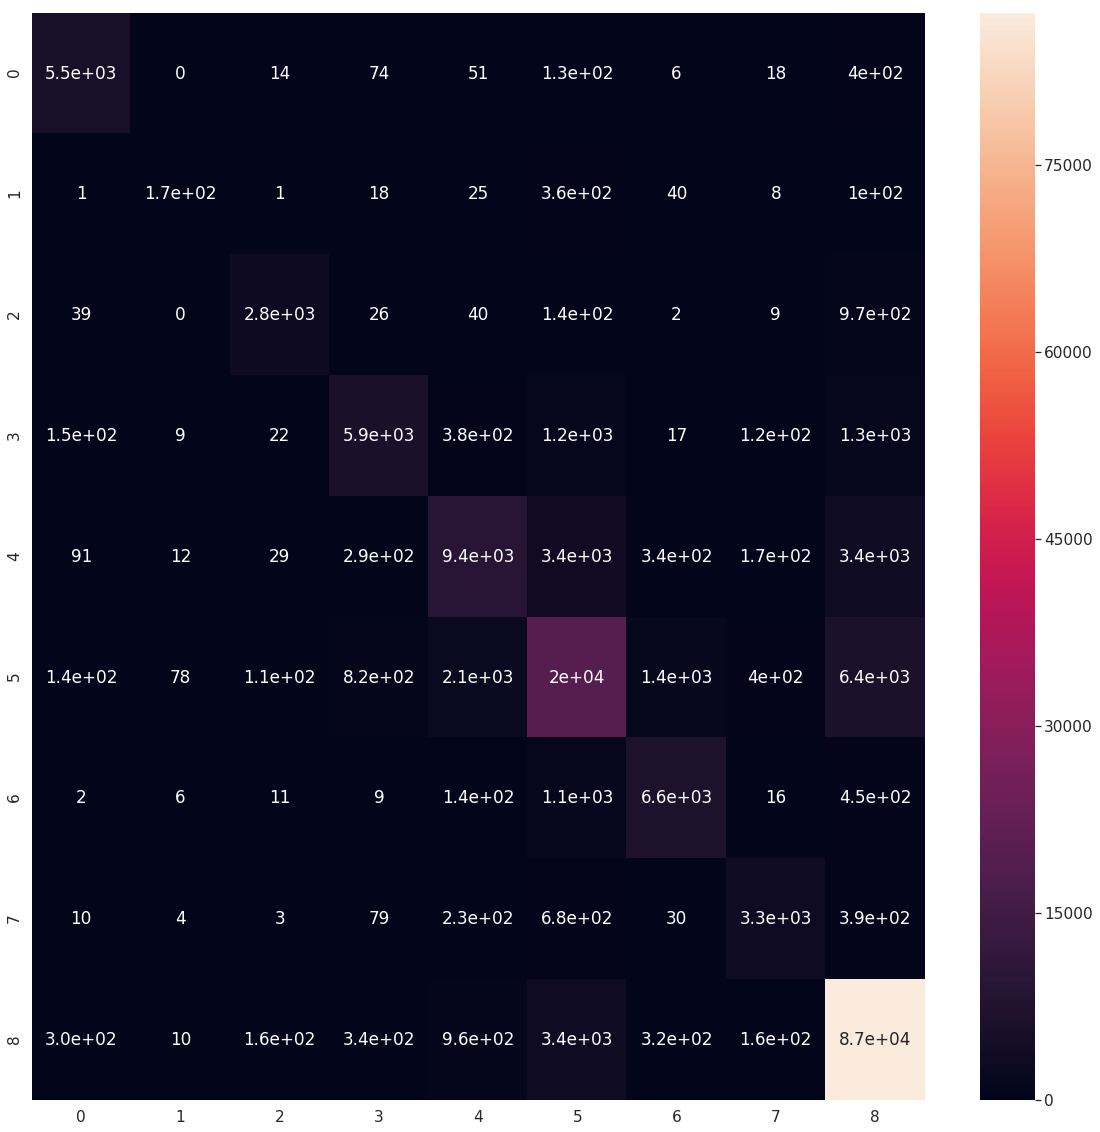

In [32]:
model_pipeline = Pipeline([
               ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,3), stop_words='english')),
#                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])

#model_pipeline = Pipeline([
              #  ('tfidf',CountVectorizer(token_pattern=r'\w{3,}', stop_words='english')),
              #  ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english')),
   # ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{3,}', stop_words='english',min_df=5)),
   #  ('tfidf', TfidfVectorizer(analyzer='word', token_pattern=r'\w{11,}',ngram_range=(1,4), stop_words='english',min_df=5)),
  #   ('tfidf', CountVectorizer(analyzer='word', token_pattern=r'\w{3,}',ngram_range=(1,11), stop_words='english',min_df=5)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
                #('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
                #('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),])
                #('clf',ensemble.RandomForestClassifier()),])
    
print('... Processing')
model_pipeline.fit(train_x,train_y)

prediction = model_pipeline.predict(valid_x)
print(prediction)
'''
pred = model_pipeline.predict_proba(valid_x)
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.5, 1, 0)
#print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(valid_y,prediction))
'''

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))

conf_mat = confusion_matrix(valid_y, prediction)
print(conf_mat)
#plt.matshow(conf_mat)
sns.set(font_scale=1.4)#for label size
plt.figure(figsize = (20,20))
sns.heatmap(conf_mat, annot=True)
joblib.dump(model_pipeline, '../picklefolder_ngrams/DeleteReason_multiclass_Feb2619_LRmodelV3.pickle')


In [36]:
pred = model_pipeline.predict_proba(valid_x)
print(pred)

[[  4.38324577e-04   5.06399710e-05   1.17667169e-03 ...,   1.30890913e-03
    8.79961681e-04   9.64408568e-01]
 [  8.79347423e-04   1.88741411e-02   7.71872314e-04 ...,   4.54858225e-01
    2.78583319e-03   2.14991487e-01]
 [  9.85817863e-01   3.77078354e-06   4.25267783e-04 ...,   6.64886845e-06
    2.77634449e-05   2.16678455e-05]
 ..., 
 [  9.64609857e-05   7.41332503e-06   2.28969537e-03 ...,   1.74748041e-05
    1.50197710e-04   9.74748786e-01]
 [  5.64937347e-04   7.14635396e-04   5.19499321e-04 ...,   9.22868944e-01
    2.93162026e-03   8.62315245e-03]
 [  1.04884237e-04   4.99055606e-04   2.51775375e-04 ...,   1.07890476e-04
    9.19832293e-04   1.07378258e-01]]


In [34]:
# only for LR model
# below is to use probability to output class prediction, then output all metrics for each threshold
'''
pred = model_pipeline.predict_proba(valid_x)
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
print("threshold accuracy_score precision recall   f1_score tn  fp fn   tp")
for thres in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:  #no, cannot use it, this is for binary class only
    prediction = np.where(y_pred > thres, 1, 0)
        #print(prediction)
    conf_mat = confusion_matrix(prediction, valid_y)
    tn, fp, fn, tp = conf_mat.ravel()
    report = classification_report(valid_y,prediction)
    lines = report.split('\n')
    #print(lines[2])
    row_data = lines[2].split('      ')
    print(thres,accuracy_score(valid_y, prediction),row_data[2],row_data[3],row_data[4], tn, fp,fn, tp)
    '''

threshold accuracy_score precision recall   f1_score tn  fp fn   tp
0.1 0.832205165397  0.95 0.26 0.40     32913 8408 482 24505 115519
0.2 0.855769101629  0.92 0.38 0.54     32913 12516 1081 20397 114920
0.3 0.869945068966  0.89 0.47 0.62     32913 15476 1930 17437 114071
0.4 0.879030850021  0.85 0.55 0.67     32913 17985 3086 14928 112915
0.5 0.884141182159  0.81 0.62 0.70     32913 20284 4624 12629 111377
0.6 0.883308486778  0.76 0.68 0.72     32913 22449 6913 10464 109088
0.7 0.874222705723  0.70 0.75 0.72     32913 24622 10439 8291 105562
0.8 0.846723612286  0.62 0.82 0.70     32913 26931 16843 5982 99158
0.9 0.730562606605  0.45 0.90 0.60     32913 29558 36768 3355 79233


In [35]:
#import os
#os.getcwd()
#joblib.dump(model_pipeline, '../picklefolder_ngrams/DeleteReason_{}_Feb1419.pickle'.format(phrase))
#joblib.dump(model_pipeline, '../picklefolder_ngrams/DeleteReason_multiclass_Feb2019_LRmodel.pickle') 
#joblib.dump(model_pipeline, '../picklefolder_ngrams/DeleteReason_NotRelevant_Feb1819_add_wellonly.pickle') 
#print("---pickle file dumped")

'/home/jovyan/work/TinaZ'

Test accuracy is 0.8067027039447607
                                      precision    recall  f1-score   support

              Class 0:family_history       0.88      0.89      0.89      6217
           Class 1:incorrect_acronym       0.59      0.24      0.34       730
             Class 2:medical_history       0.89      0.70      0.78      4017
                    Class 3:negation       0.78      0.65      0.71      9083
            Class 4:not_doctors_note       0.70      0.55      0.62     17160
                Class 5:not_relevant       0.65      0.63      0.64     31098
Class 6:phoneORaddressORother_number       0.76      0.80      0.78      8259
      Class 7:preventative_screening       0.79      0.70      0.74      4770
              Class 8:agreedandadded       0.87      0.94      0.90     92745

                           micro avg       0.81      0.81      0.81    174079
                           macro avg       0.77      0.68      0.71    174079
                        we

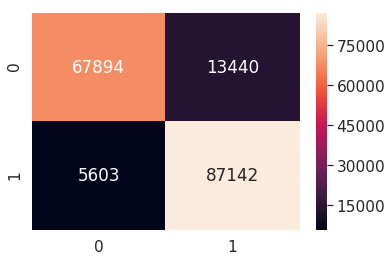

In [33]:
print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
target_names = ['Class 0:family_history', 'Class 1:incorrect_acronym', 'Class 2:medical_history',
       'Class 3:negation', 'Class 4:not_doctors_note', 'Class 5:not_relevant',
       'Class 6:phoneORaddressORother_number', 'Class 7:preventative_screening', 'Class 8:agreedandadded']
print(classification_report(valid_y, prediction, target_names=target_names))
# now divide the deletion vs agreed+added 
print('after converting to binary class:')
valid_y_2b = (valid_y > 7).astype(np.int)
prediction_2b= (prediction > 7).astype(np.int)

print('Test accuracy is {}'.format(accuracy_score(valid_y_2b, prediction_2b)))
conf_mat = confusion_matrix(valid_y_2b, prediction_2b)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(valid_y_2b,prediction_2b))

In [34]:
# for multiclass model
print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
target_names = ['Class 0:family_history', 'Class 1:incorrect_acronym', 'Class 2:medical_history',
       'Class 3:negation', 'Class 4:not_doctors_note', 'Class 5:not_relevant',
       'Class 6:phoneORaddressORother_number', 'Class 7:preventative_screening', 'Class 8:agreedandadded']
print(classification_report(valid_y, prediction, target_names=target_names))
# try to find the TN,TP,FN,FP
import numpy as np
FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("TP is",TP)
print("TN is",TN)
print("FP is",FP)
print("FN is",FN)



Test accuracy is 0.8067027039447607
                                      precision    recall  f1-score   support

              Class 0:family_history       0.88      0.89      0.89      6217
           Class 1:incorrect_acronym       0.59      0.24      0.34       730
             Class 2:medical_history       0.89      0.70      0.78      4017
                    Class 3:negation       0.78      0.65      0.71      9083
            Class 4:not_doctors_note       0.70      0.55      0.62     17160
                Class 5:not_relevant       0.65      0.63      0.64     31098
Class 6:phoneORaddressORother_number       0.76      0.80      0.78      8259
      Class 7:preventative_screening       0.79      0.70      0.74      4770
              Class 8:agreedandadded       0.87      0.94      0.90     92745

                           micro avg       0.81      0.81      0.81    174079
                           macro avg       0.77      0.68      0.71    174079
                        we

In [37]:
'''
#pred = model_pipeline.predict_proba(valid_x)
#print(pred)
y_pred = []
for row in pred:
    y_pred.append(row[1])
y_pred = np.array(y_pred)
prediction = np.where(y_pred > 0.1, 1, 0)
print(prediction)

print('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))
conf_mat = confusion_matrix(valid_y, prediction)
df_cm = pd.DataFrame(conf_mat, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(prediction, valid_y))
'''

"\npred = model_pipeline.predict_proba(valid_x)\nprint(pred)\ny_pred = []\nfor row in pred:\n    y_pred.append(row[1])\ny_pred = np.array(y_pred)\nprediction = np.where(y_pred > 0.1, 1, 0)\nprint(prediction)\n\nprint('Test accuracy is {}'.format(accuracy_score(valid_y, prediction)))\nconf_mat = confusion_matrix(valid_y, prediction)\ndf_cm = pd.DataFrame(conf_mat, range(2),\n                  range(2))\nsns.set(font_scale=1.4)#for label size\nsns.heatmap(df_cm, annot=True, fmt='d')\nprint(classification_report(prediction, valid_y))\n"